In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

A notebook for testing the models.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

#from tsfresh.transformers import RelevantFeatureAugmenter

import xgboost as xgb

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('white')
sns.set(color_codes=True)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%cd /content/gdrive/My Drive/DS4A/Project_models

/content/gdrive/My Drive/DS4A/Project_models


In [ ]:
path = {'cucuta':'cucuta_consolidado_2007_2020.csv',
        'cali':'cali_consolidado_2007_2020.csv',
        'barranquilla':'barranquilla_consolidado_2013_2020.csv',
        'santa_marta':'santa_marta_consolidado_2008_2020.csv'
        }

In [ ]:
city = 'cucuta'

In [ ]:
df = pd.read_csv('Data/'+path[city])
df['FECHA'] = pd.to_datetime(df['FECHA'])
df.drop(columns=['COD_DPTO','COD_MUNICIPIO','POBLACION'], inplace=True)
df.fillna(method='ffill', inplace=True)
df.set_index('FECHA', inplace=True)

In [ ]:
best_features = pd.read_csv('best_features_'+city+'.csv')

In [ ]:
df_features_complete = df[df.columns[:-3]]
df_target_complete = df[df.columns[-3:]]
#As said at the beginnig, the last 8 entries are the test set for forecasting models, so they are taken back.

In [ ]:
scaler_test = StandardScaler()
scaler_test.fit(df_features_complete)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
std_df_features_complete = pd.DataFrame(scaler_test.transform(df_features_complete)).set_index(df.index)
std_df_features_complete = pd.concat([std_df_features_complete, df_target_complete['DENGUE']], axis=1)
std_df_features_complete.columns = list(df_features_complete.columns) + ['DENGUE']

In [ ]:
def lagged_df(df, lag_size):
  dfs = list()
  for i in range(lag_size):
    df_lag = df.shift(i+1)
    df_lag.columns = [col+'_lag_'+str(i+1) for col in df.columns]
    dfs.append(df_lag)
  return pd.concat([df]+dfs, axis=1)

In [ ]:
std_df_features_complete_lag = lagged_df(std_df_features_complete, 12)

In [ ]:
def data_forecast(n):
  features = std_df_features_complete_lag[best_features[str(n)+'_weeks_ahead'].to_list()].iloc[12:-n]
  labels = df_target_complete.shift(-n).iloc[12:-n]
  return features, labels

In [ ]:
def data_forecast_cut(n):
  features_train, features_test, labels_train, labels_test = train_test_split(data_forecast(n)[0], data_forecast(n)[1],
                                                                              test_size=8, shuffle=False)
  return features_train, features_test, labels_train, labels_test

#Poisson

In [ ]:
def poisson_models():
  models = []
  for i in range(8):
    df_temp = data_forecast_cut(i+1)[0]
    df_temp['intercept']=1
    poisson_model_res = sm.GLM(data_forecast_cut(i+1)[2]['DENGUE'], df_temp, family=sm.families.Poisson()).fit()
    models.append(poisson_model_res)
  return models

In [ ]:
poisson_models_lst = poisson_models()

In [ ]:
def poisson_predict(position):
  predictions = []
  for i in range(8):
    df_temp = std_df_features_complete_lag[best_features[str(i+1)+'_weeks_ahead'].to_list()]
    df_temp['intercept']=1
    if position==-1:
      prediction = poisson_models_lst[i].get_prediction(df_temp.iloc[position:]).summary_frame()['mean'].values
    else:
      prediction = poisson_models_lst[i].get_prediction(df_temp.iloc[position:position+1]).summary_frame()['mean'].values
    predictions.append(prediction[0])
  predictions_with_date = pd.Series(predictions, index=pd.date_range(df_temp.index[position], freq='W-SUN', periods=9)[1:])
  return predictions_with_date#pd.concat([df_target_complete['DENGUE'], predictions_with_date])

In [ ]:
poisson_pred = poisson_predict(-9)#.to_csv('poisson_ensemble_predictions_'+city+'.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#Nb

In [ ]:
def nb_models():
  models = []
  for i in range(8):
    df_temp = data_forecast_cut(i+1)[0]
    df_temp['intercept']=1

    best_alpha_df = pd.DataFrame({'DENGUE':data_forecast_cut(i+1)[2]['DENGUE'],'mu':poisson_models()[i].mu})
    best_alpha_df['aux_ols'] = ((best_alpha_df['DENGUE']-best_alpha_df['mu'])**2-best_alpha_df['DENGUE'])/best_alpha_df['mu']

    ols_expr = """aux_ols ~ mu - 1"""
    aux_ols_results = smf.ols(ols_expr, best_alpha_df).fit()
    best_alpha = aux_ols_results.params[0]

    nb_model_res = sm.GLM(data_forecast_cut(i+1)[2]['DENGUE'], df_temp, family=sm.families.NegativeBinomial(alpha=best_alpha)).fit()
    models.append(nb_model_res)
  return models

In [ ]:
nb_models_lst = nb_models()

In [ ]:
def nb_predict(position):
  predictions = []
  for i in range(8):
    df_temp = std_df_features_complete_lag[best_features[str(i+1)+'_weeks_ahead'].to_list()]
    df_temp['intercept']=1
    if position==-1:
      prediction = nb_models_lst[i].get_prediction(df_temp.iloc[position:]).summary_frame()['mean'].values
    else:  
      prediction = nb_models_lst[i].get_prediction(df_temp.iloc[position:position+1]).summary_frame()['mean'].values
    predictions.append(prediction[0])
  predictions_with_date = pd.Series(predictions, index=pd.date_range(df_temp.index[position], freq='W-SUN', periods=9)[1:])
  return predictions_with_date #pd.concat([df_target_complete['DENGUE'], predictions_with_date])

In [ ]:
nb_pred = nb_predict(-9)#.to_csv('negative_binomial_ensemble_predictions_'+city+'.csv')

#XGBRegressor

In [ ]:
def xgb_models():
  models = []
  for i in range(8):
    xgb_model_res = xgb.XGBRegressor(objective="reg:squarederror", random_state=1,
                                     booster='gbtree').fit(data_forecast_cut(i+1)[0],
                                                           data_forecast_cut(i+1)[2]['DENGUE'])
    models.append(xgb_model_res)
  return models

In [ ]:
xgb_models_lst = xgb_models()

In [ ]:
def xgb_predict(position):
  predictions = []
  for i in range(8):
    df_temp = std_df_features_complete_lag[best_features[str(i+1)+'_weeks_ahead'].to_list()]
    if position==-1:
      prediction = xgb_models_lst[i].predict(df_temp.iloc[position:])[0]
    else:
      prediction = xgb_models_lst[i].predict(df_temp.iloc[position:position+1])[0]
    predictions.append(prediction)
  predictions_with_date = pd.Series(predictions, index=pd.date_range(df_temp.index[position], freq='W-SUN', periods=9)[1:])
  return predictions_with_date #pd.concat([df_target_complete['DENGUE'], predictions_with_date])

In [ ]:
xgb_pred = xgb_predict(-9)#.to_csv('xgboost_ensemble_predictions_'+city+'.csv')

#MLP

In [ ]:
mlp_model = MLPRegressor(random_state=1, max_iter=1000)
param_list = {"hidden_layer_sizes": [1,25], "activation": ["logistic", "relu"], "solver": ["sgd", "adam"], "alpha": [0.00005,0.0005]}

In [ ]:
mlp_gridCV = GridSearchCV(estimator=mlp_model, param_grid=param_list, cv=TimeSeriesSplit(3))

In [ ]:
def mlp_models():
  models = []
  for i in range(8):
    mlp_model_res = mlp_gridCV.fit(data_forecast_cut(i+1)[0], data_forecast_cut(i+1)[2]['DENGUE'])
    models.append(mlp_model_res)
  return models

In [ ]:
#mlp_models_lst = mlp_models()

In [ ]:
def mlp_predict(position):
  predictions = []
  for i in range(8):
    df_temp = std_df_features_complete_lag[best_features[str(i+1)+'_weeks_ahead'].to_list()]
    if position==-1:
      prediction = mlp_models_lst[i].predict(df_temp.iloc[position:])[0]
    else:
      prediction = mlp_models_lst[i].predict(df_temp.iloc[position:position+1])[0]
    predictions.append(prediction)
  predictions_with_date = pd.Series(predictions, index=pd.date_range(df_temp.index[position], freq='W-SUN', periods=9)[1:])
  return predictions_with_date #pd.concat([df_target_complete['DENGUE'], predictions_with_date])

In [ ]:
#mlp_predict(-1).to_csv('mlp_ensemble_predictions_'+city+'.csv')

#Plots

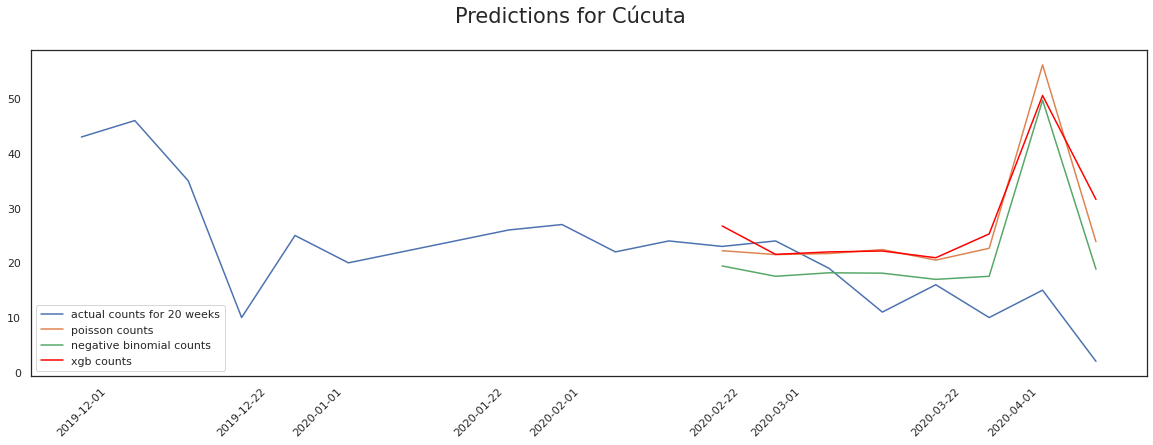

In [ ]:
fig = plt.figure(figsize=(20,6))
fig.suptitle('Predictions for Cúcuta', fontsize=21)
plt.xticks(rotation=45)
sns.lineplot(data=df_target_complete['DENGUE'].iloc[-20:], label='actual counts for 20 weeks')
sns.lineplot(data=poisson_pred, label='poisson counts')
sns.lineplot(data=nb_pred, label='negative binomial counts')
sns.lineplot(data=xgb_pred, label='xgb counts', color='red')
#sns.lineplot(data=mlp_predict(-1))

In [ ]:
(df_target_complete['DENGUE'].var(), df_target_complete['DENGUE'].mean())

(1339.5942483709064, 51.75936599423631)

In [ ]:
mae(nb_pred, df_target_complete['DENGUE'].iloc[-8:])

9.757533578651017

In [ ]:
#plt.figure(figsize=(20,7))
#sns.lineplot(data=df_target_complete['DENGUE'].iloc[-20:], label='actual counts for 20 weeks')
#sns.lineplot(data=poisson_pred, label='poisson counts')
#sns.lineplot(data=nb_pred, label='negative binomial counts')
#sns.lineplot(data=xgb_pred, label='xgb counts', color='red')
#sns.lineplot(data=mlp_predict(-1)) CALI

In [ ]:
#dengue.shape

In [ ]:
#dengue[dengue['DENGUE']==0].shape[0]/dengue.shape[0]